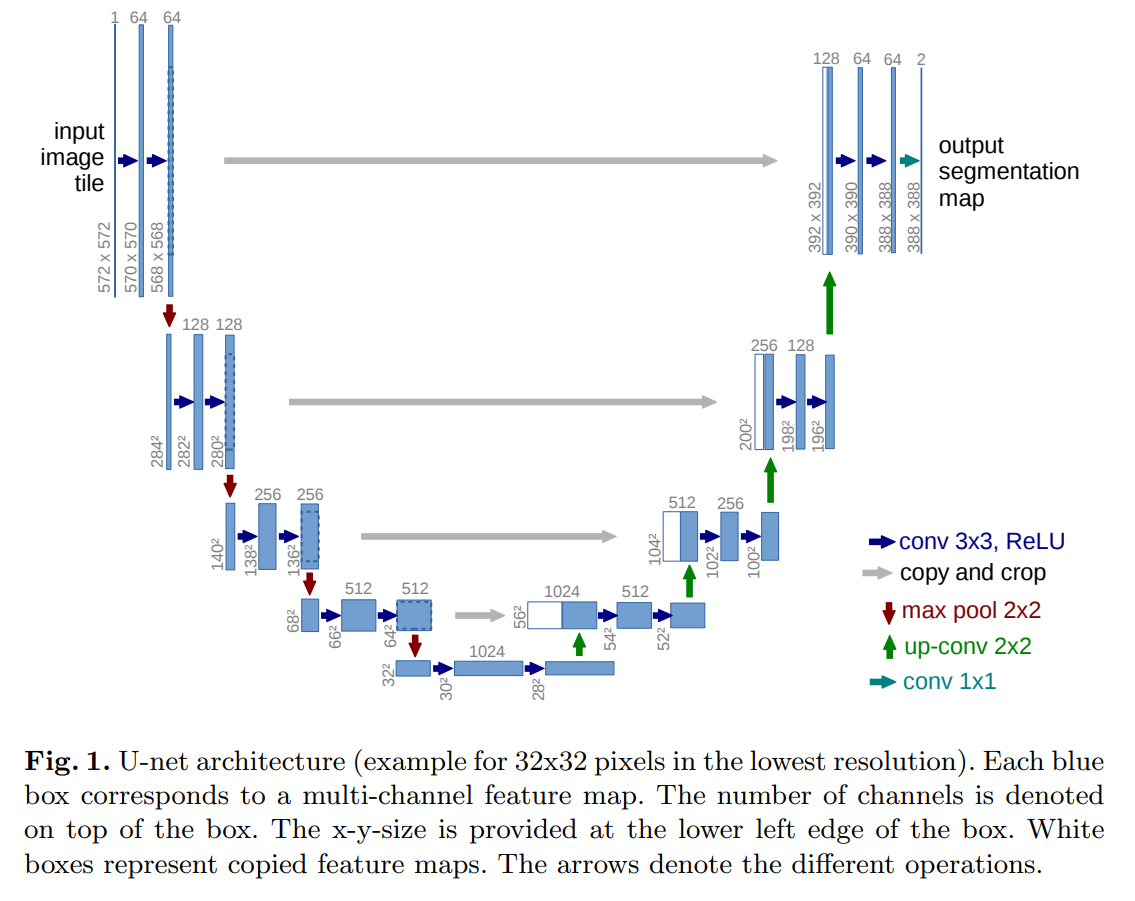

In [34]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset


import pandas as pd
import numpy as np
from pathlib import Path

In [35]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # Same Conv
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # Same Conv
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

# -- Some Notes --
# Input - 572 x 572 x 1 (WxHxC)
# After 1st 3x3 conv (with padding=1), output_size = (572 - 3 + 2*1)/1 + 1 = 572 (Same Convolution)
# BatchNorm
# ReLU
# After 2nd 3x3 conv  - Output size = 572 
# BatchNorm
# ReLU 

# That is, after double conv, input size will be same as ouput size, 

**Some points about implementation :**
- Original UNet architecture shown in the picture is without padding. We'll use `padding=1`, this will make it same convolution, `bias=False`, because we are going to use `BatchNorm2d`

- Original paper was in 2015, batchnorm paper came in 2016, so `bias=True` in the original architecture and `BatchNorm` was non-existent.

- `super(DoubleConv, self).__init__()`: This line calls the constructor of the parent class (`nn.Module`). This is necessary to properly initialize the inherited parts of the class.

-  `self.conv = nn.Sequential(...)`: This line creates an attribute `conv` in the `DoubleConv` class that is an instance of `nn.Sequential`. The `nn.Sequential` container initializes a sequence of modules which will be added to it in the order they are passed in the constructor. When an input is passed to an `nn.Sequential` module, it is sequentially passed through all the modules it contains.

   - `nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)`: This line adds a 2D convolutional layer to the sequence. The layer will take an input with `in_channels`, apply convolutional filters, and produce an output with `out_channels`. The filters will have a size of 3x3 (`kernel_size=3`), with a stride of 1 (`stride=1`) and padding of 1 (`padding=1`). `bias=False` indicates that this layer will not use bias parameters.
   
      Setting `bias=False` in the convolutional layer when it is immediately followed by batch normalization is a common practice. Here's why:

      1. **Redundancy**: Batch normalization (BatchNorm) layers normalize the output of the previous layer by subtracting the batch mean and dividing by the batch standard deviation. Then, it applies two learnable parameters: gamma (scale) and beta (shift). Since the beta parameter in the BatchNorm layer has the same effect as the bias in the convolutional layer (shifting the activation to higher or lower values), having both can be redundant. The beta parameter in the batch normalization can take over the role of bias.

      2. **Parameter Efficiency**: By setting `bias=False`, you reduce the number of parameters in your model, which can lead to a small reduction in memory usage and computational demand. While for small models or layers the difference is negligible, in large-scale networks with many convolutional layers, this can add up.

      3. **Improved Stability**: Batch normalization helps stabilize the learning process and reduces the sensitivity to the initialization of the network. The batch normalization's shift parameter (beta) will adjust during training to the appropriate bias for the normalized inputs, potentially leading to better training performance.

   - `nn.BatchNorm2d(out_channels)`: This line adds a batch normalization layer to the sequence, which normalizes the output of the previous layer. It uses the number of output channels from the convolutional layer.

   - `inplace` Argument in `nn.ReLU`: The `inplace` parameter is a boolean that, when set to `True`, will modify the input directly, without allocating any additional output. It can make the operation slightly more memory efficient since it does not need to save the previous values of the input tensor since they are overwritten with the output.

* In the papaer they had out_channels=2, but we are going to do binary image segmenation, so we can just output single channel
* you can't use normal list, beacuse we are going to be storing the convolution layers
  - why this is important is that we are going to do module.eval() and stuff like that for Batch Normalization  and so on and that's why you want to have this module list
* Bottom part of 'U' shape will be created outside for loops. 
* For upsampling part we'll going to be doing transposed convolutions. What you could also do here is to do bilinear and then conv layer afterwords and (GAN and pro-GAN they realised that transposed convolutions create these artifacts and they started to use that, I amagine that will be a better and cheaper option). But we'll stick to the paper.

In [36]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs      = nn.ModuleList()
        self.up_convs   = nn.ModuleList()
        self.ups        = nn.ModuleList()
        self.pool       = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels=3, kernel_size=1)
    
        # Implemenation of DOWN part ->
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature)) # 2 Conv
            in_channels = feature
        
        # Implementation of up-conv 2x2
        for feature in reversed(features):
            self.up_convs.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) # UP
                                 
        # Implemenation of UP part -> (except last 1x1 conv)
        for feature in reversed(features):
            self.ups.append(DoubleConv(feature*2, feature)) # 2 Conv
            
        # lowest part of 'U'
        self.bottleneck = DoubleConv(features[-1], 2*features[-1])
    
    # Implementation of cropping function for skip connection
    def crop_tensor(self, target_tensor, ref_tensor):
        # Calcualte the cropping size fo the spatial dimensions (H & W)
        delta_h = target_tensor.shape[2] - ref_tensor.shape[2]
        delta_w = target_tensor.shape[3] - ref_tensor.shape[3]
        
        # Actually this code part is redundant as skip connection size will always
        # be larger than the size after max-pool
        crop_h1 = max(delta_h//2, 0)
        crop_w1 = max(delta_w//2, 0)
        
        crop_h2 = crop_h1 + ref_tensor.shape[2]
        crop_w2 = crop_w1 + ref_tensor.shape[3]
        
        crop_h2 = min(crop_h2, target_tensor.shape[2])
        crop_w2 = min(crop_w2, target_tensor.shape[3])
        
        return target_tensor[:, :, crop_h1:crop_h2, crop_w1:crop_w2]
            
    def forward(self, x):
        skip_conn = []
        
        idx = 0
        for down in self.downs:
            x = down(x)
            skip_conn.append(x)
            print(f'Before Pool : x.shape : {x.shape}')
            x = self.pool(x)
            print(f'After Pool : x.shape : {x.shape}')
            idx += 1
        
        x = self.bottleneck(x)
    
        idx = 0
        skip_conn = skip_conn[::-1]
        for up_conv, up in zip(self.up_convs, self.ups):
            x = up_conv(x)
            if x.shape != skip_conn[idx].shape:
                print(f'x.shape : {x.shape}, skip_conn[{idx}].shape : {skip_conn[idx].shape}')
                skip_conn[idx] = self.crop_tensor(skip_conn[idx], x)
            x = torch.concat((x, skip_conn[idx]), dim=1)
            x = up(x)
            
            idx += 1
        
        # print(x.shape)
        final = self.final_conv(x)
        # print(final.shape)
        return final
    
# def test():
#     x = torch.randn((1, 3, 512, 512))
#     model = UNet(in_channels=3, out_channels=2)
#     pred = model(x)
#     print(x.shape)
#     print(pred.shape)
    
# test()

In [39]:
TRAIN_ROOT_DIR = Path('/home/onkar/DATASET/carvana-image-masking-challenge/train')

TRAIN_IMG_FILES_DIR = TRAIN_ROOT_DIR/'train'
TRAIN_MSK_FILES_DIR = TRAIN_ROOT_DIR/'train_masks'

# 00087a6bd4dc_12.jpg,00087a6bd4dc_10_mask.gif
# 00087a6bd4dc_11.jpg,00087a6bd4dc_11_mask.gif
# 00087a6bd4dc_10.jpg,00087a6bd4dc_12_mask.gif

fig, axes 



# 
# pd.read_csv(TRAIN_ROOT_DIR/'train_masks.csv')

In [38]:
class CaravanaDataset(Dataset):
    def __int__(self, root_dir, transform):
        super(CaravanaDataset, self).__init__()
        self.all_files = self.extract_files(root)
    
    def __len__(self):
        return None
    
    def __getitem__(self, idx):
        return None    